In [3]:
cd /home

/home


In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [129]:
runs = pd.read_csv('./presentation/results/runs.csv')
runs = runs[~runs['data_path'].isna()]

In [130]:
selected = runs[runs['astromer']=='frozen']

selected['spc'] = selected['data_path'].apply(lambda x: x.split('_')[-1])

/tmp/ipykernel_67/3768343815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['spc'] = selected['data_path'].apply(lambda x: x.split('_')[-1])


In [131]:
selected_2 = selected[['m_alpha', 'spc', 'Name', 'probed', 'rs', 'clf_test_f1']]
selected_2 = selected_2[~selected_2['clf_test_f1'].isna()]

In [132]:
summary_mean = selected_2.groupby(['m_alpha', 'spc'])['clf_test_f1'].mean().reset_index()
summary_std = selected_2.groupby(['m_alpha', 'spc'])['clf_test_f1'].std().reset_index()
summary = pd.merge(summary_mean, summary_std, on=['m_alpha', 'spc'])
summary['spc'] = summary['spc'].astype(int)

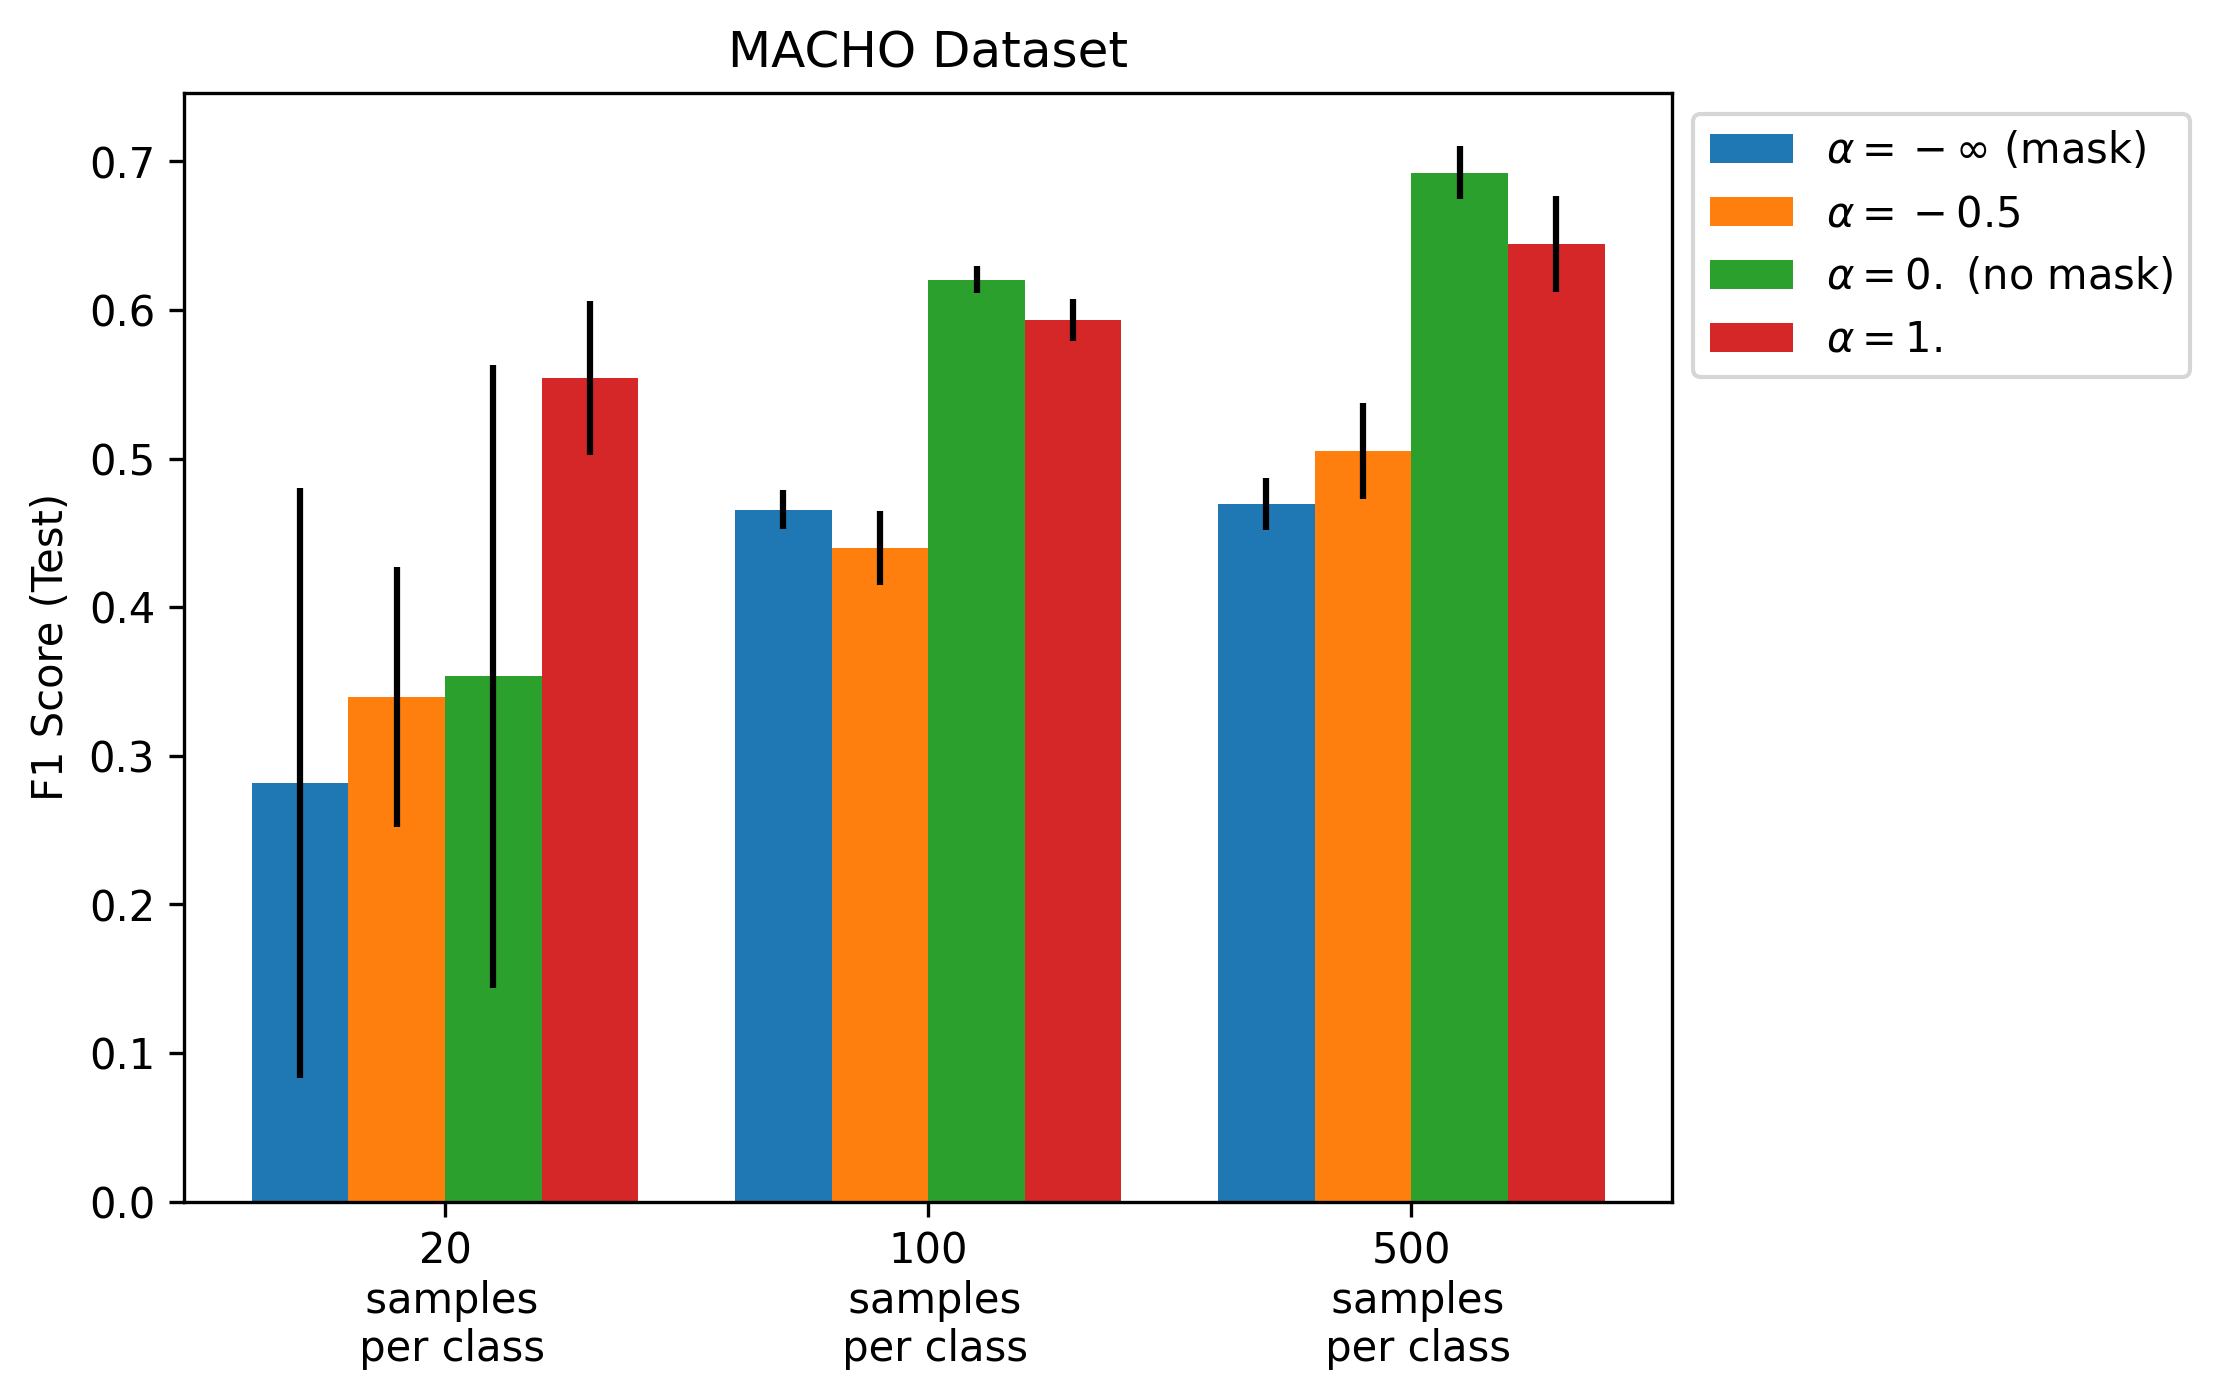

In [139]:
off = 0.
offsets = []
plt.figure(dpi=300)
for alph, frame in summary.groupby('m_alpha'):
    frame = frame.sort_values('spc')
    X_axis = np.arange(frame.shape[0]) + off
    plt.bar(X_axis, frame['clf_test_f1_x'], yerr=frame['clf_test_f1_y'], width=0.2, label=alph)
    off+=0.2
    offsets.append(off)

plt.xticks(np.linspace(0.3, X_axis[-1]-0.3, 3), ['20\n samples\n per class', '100\n samples\n per class', '500\n samples\n per class'])
plt.legend([r'$\alpha = -\infty$ (mask)', 
            r'$\alpha = -0.5$', 
            r'$\alpha = 0.$ (no mask)', 
            r'$\alpha = 1.$ '], bbox_to_anchor=(1., 1.0))
plt.title('MACHO Dataset')
plt.ylabel('F1 Score (Test)')
plt.show()